In [19]:
import os
from os import path
from astropy.io import fits
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
import astropy.units as u
from astropy.wcs import WCS
from copy import deepcopy
from calibrimbore.bill import get_skymapper_region
%matplotlib widget

from scipy.ndimage.filters import convolve
from scipy.ndimage import gaussian_filter
from copy import deepcopy

from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
import pandas as pd
from astroquery.vizier import Vizier

from scipy.optimize import minimize

def get_gaia_region(ra,dec,size=0.4, magnitude_limit = 21):
	"""
	Get the coordinates and mag of all gaia sources in the field of view.

	-------
	Inputs-
	-------
		tpf 				class 	target pixel file lightkurve class
		magnitude_limit 	float 	cutoff for Gaia sources
		Offset 				int 	offset for the boundary 
	
	--------
	Outputs-
	--------
		coords 	array	coordinates of sources
		Gmag 	array 	Gmags of sources
	"""
	c1 = SkyCoord(ra, dec, unit='deg')
	Vizier.ROW_LIMIT = -1

	result = Vizier.query_region(c1, catalog=["I/355/gaiadr3"],
                             		 radius=Angle(size, "arcsec"),column_filters={'Gmag':f'<{magnitude_limit}'})

	keys = ['objID','RAJ2000','DEJ2000','e_RAJ2000','e_DEJ2000','gmag','e_gmag','gKmag','e_gKmag','rmag',
			'e_rmag','rKmag','e_rKmag','imag','e_imag','iKmag','e_iKmag','zmag','e_zmag','zKmag','e_zKmag',
			'ymag','e_ymag','yKmag','e_yKmag','tmag','gaiaid','gaiamag','gaiadist','gaiadist_u','gaiadist_l',
			'row','col']


	no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
	if result is None:
		raise no_targets_found_message
	elif len(result) == 0:
		raise no_targets_found_message
	

	result = result['I/355/gaiadr3'].to_pandas()
	result = result.rename(columns={'RA_ICRS':'ra','DE_ICRS':'dec'})
	return result



<ipython-input-19-268e323e70d1>:16: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [2]:
hdul = fits.open('2I_DATACUBE_FINAL_2019-12-31T06:22:04.886.fits')
wcs = WCS('2I_DATACUBE_FINAL_2019-12-31T06:22:04.886.fits')

hdul = fits.open('2I_DATACUBE_FINAL_2020-03-19T05:46:49.016.fits')
wcs = WCS('2I_DATACUBE_FINAL_2020-03-19T05:46:49.016.fits')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
wcs = WCS(hdul[1].header)
data = hdul[1].data

In [4]:
ra,dec, lam = wcs.all_pix2world(data.shape[2]/2,data.shape[1]/2,100,0)

In [5]:
#cat = get_skymapper_region([ra],[dec],size=100)
cat = get_gaia_region([ra],[dec],size=50)

In [6]:
x, y, lam = wcs.all_world2pix(cat.ra.values,cat.dec.values,0,0)

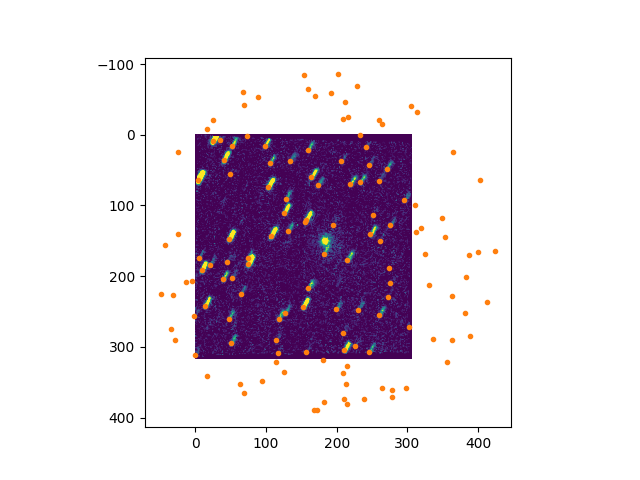

In [33]:
plt.figure()
plt.imshow(data[500],vmin=0,vmax=100)
plt.plot(x+22,y,'C1.')

In [34]:
image = data[500]
image[np.isnan(image)] = 0
image = gaussian_filter(image,3)

In [35]:
n_head = deepcopy(hdul[1].header)
n_head['NAXIS'] = 2
del n_head['C*']
del n_head['NAXIS3']
del n_head['BUNIT']


In [36]:
fits.writeto('test.fits',image,header=n_head,overwrite=True)

In [25]:
tmp = os.environ['TMPDIR']
name = 'wcs/test_wcs'
inter = 'test.fits'
astrom_call = f"solve-field --no-plots --scale-units arcminwidth --scale-low 0.9 --scale-high 1.1 --temp-dir {tmp} -O -o {name} -p --ra {ra} --dec {dec} --radius 0.2 {inter}"

os.system(astrom_call)

0

In [37]:
#mean, med, std = sigma_clipped_stats(image, sigma=3.0)
#daofind = DAOStarFinder(fwhm=1.0, threshold=1,exclude_border=True)
#s = daofind(image - med).to_pandas()
astrom = fits.open('test_wcs.axy')[1].data

In [38]:
sourcex = astrom['X']; sourcey = astrom['Y']
i = 20
buffer = 4
lowy = int(sourcey[i]-buffer)
highy = int(sourcey[i]+buffer+1)
lowx = int(sourcex[i]-buffer)
highx = int(sourcex[i]+buffer+1)
if lowy < 0:
    lowy = 0
if lowx < 0:
    lowx = 0
thing = image[lowy:highy,lowx:highx]

np.where(thing == np.nanmax(thing))

(array([4]), array([3]))

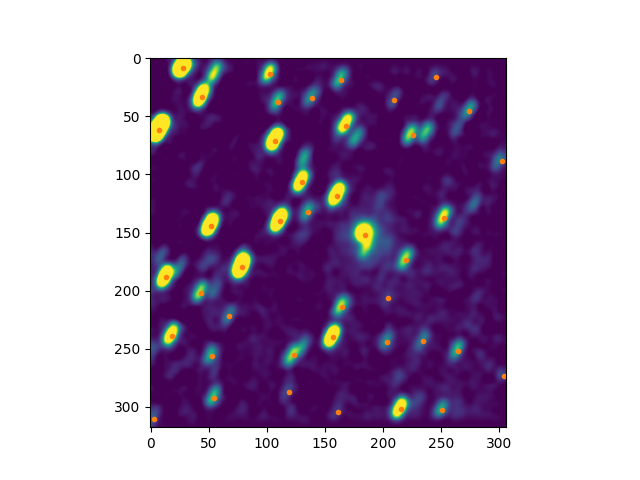

In [39]:
plt.figure()
plt.imshow(image,vmin=0,vmax=50)
#plt.plot(s.xcentroid.values,s.ycentroid.values,'.')
plt.plot(astrom['X'],astrom['Y'],'C1.')

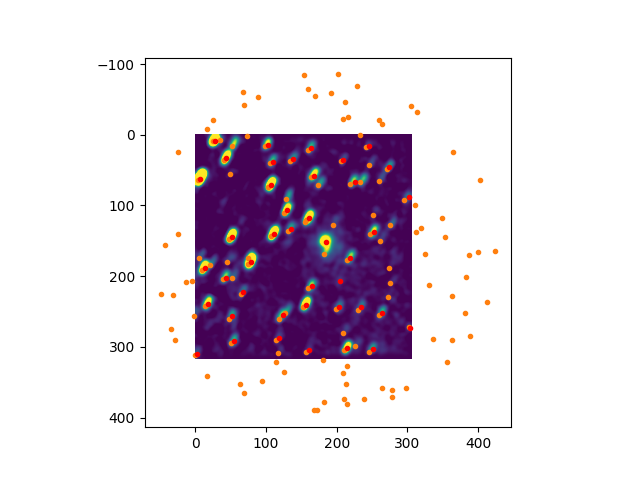

In [40]:
plt.figure()
plt.imshow(image,vmin=0,vmax=50)
plt.plot(x+22,y,'C1.')
plt.plot(astrom['X'],astrom['Y'],'r.')

In [44]:
cat['Gmag'].values < 19

array([ True, False, False,  True,  True, False, False, False,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True, False, False,  True, False, False,  True,
        True, False,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True, False,  True, False,
       False, False,

In [48]:
def min_dist(x1,y1,x2,y2):
    dx = x1[:,np.newaxis] - x2[np.newaxis,:]
    dy = y1[:,np.newaxis] - y2[np.newaxis,:]
    d = np.sqrt(dx**2 + dy**2)
    md = np.nanmin(d,axis=1)
    return md

def minimize_dist(offset,x1,y1,x2,y2,image):
    cx = image.shape[1]/2; cy = image.shape[0]/2
    x = x1 + offset[0]
    y = y1 + offset[1]
    x = cx + ((x-cx)*np.cos(offset[2])-(y-cy)*np.sin(offset[2]))
    y = cy + ((x-cx)*np.sin(offset[2])+(y-cy)*np.cos(offset[2]))

    ind = (x > 0) & (x < image.shape[1]) & (y > 0) & (y < image.shape[0])
    x = x[ind]; y = y[ind]
    mdist = min_dist(x2,y2,x,y)
    return np.nanmean(mdist)

x0 = [0,0,0]

ind = cat['Gmag'].values < 20

x, y, lam = wcs.all_world2pix(cat.ra.values[ind],cat.dec.values[ind],0,0)

catx = x; caty = y
sourcex = astrom['X']; sourcey = astrom['Y']

res = minimize(minimize_dist,x0,args=(catx,caty,sourcex,sourcey,image))

xx = x + res.x[0]
yy = y + res.x[1]
cx = image.shape[1]/2; cy = image.shape[0]/2
xx = cx + ((xx-cx)*np.cos(res.x[2])-(yy-cy)*np.sin(res.x[2]))
yy = cy + ((xx-cx)*np.sin(res.x[2])+(yy-cy)*np.cos(res.x[2]))

#ind = (xx > 0) & (xx < image.shape[1]) & (yy > 0) & (yy < image.shape[0])
#xx = xx[ind]; yy = yy[ind]

cut = min_dist(xx,yy,sourcex,sourcey) < 5
print('round 1: ',res.x)
res = minimize(minimize_dist,x0,args=(catx[cut],caty[cut],sourcex,sourcey,image))
print('round 2: ',res.x)


round 1:  [ 2.59384808e+01 -2.78476095e+00 -6.27431837e-04]
round 2:  [ 2.58261855e+01 -2.68797494e+00 -1.57083263e-03]


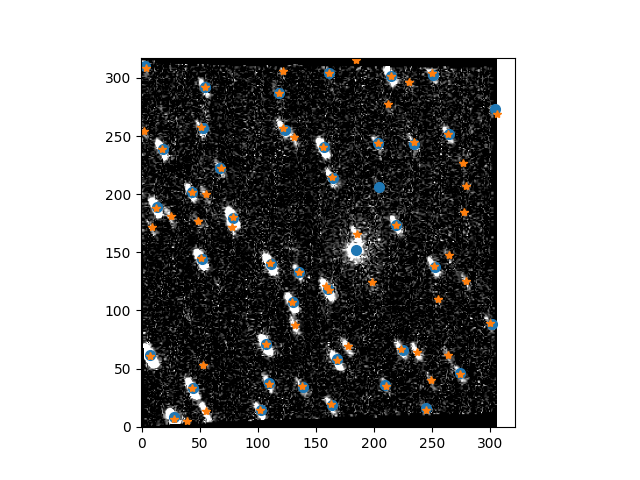

In [49]:
x, y, lam = wcs.all_world2pix(cat.ra.values,cat.dec.values,0,0)
xx = x + res.x[0]
yy = y + res.x[1]
cx = image.shape[1]/2; cy = image.shape[0]/2
xx = cx + ((xx-cx)*np.cos(res.x[2])-(yy-cy)*np.sin(res.x[2]))
yy = cy + ((xx-cx)*np.sin(res.x[2])+(yy-cy)*np.cos(res.x[2]))

ind = (xx > 0) & (xx < image.shape[1]) & (yy > 0) & (yy < image.shape[0])
xx = xx[ind]; yy = yy[ind]
gaia = cat.iloc[ind]

plt.figure()
plt.imshow(data[500],vmin=0,vmax=50,cmap='gray',origin='lower')
plt.plot(astrom['X'],astrom['Y'],'o',ms=7)
plt.plot(xx,yy,'C1*')


In [50]:
G = cat['Gmag'].values
B = cat['BPmag'].values
R = cat['RPmag'].values

gbp = G - B
grp = G - R
bprp = B - R

In [51]:
syn = pd.read_csv('ckmodel_Gaia_colors.csv')

In [54]:
syn.keys()

Index(['model', 'G-Bp', 'G-Rp', 'Bp-Rp'], dtype='object')

In [55]:
diff = np.sqrt((gbp[:,np.newaxis] - syn['G-Bp'].values[np.newaxis,:])**2 + (grp[:,np.newaxis] - syn['G-Rp'].values[np.newaxis,:])**2 + (bprp[:,np.newaxis] - syn['Bp-Rp'].values[np.newaxis,:])**2)

In [63]:
inds = np.argmin(diff,axis=1)

In [64]:
syn.iloc[inds]

,model,G-Bp,G-Rp,Bp-Rp
21,ckmod3950_0.0_1.50.dat,-0.691966,0.624646,1.316612
23,ckmod4350_0.0_4.50.dat,-0.534785,0.519873,1.054658
23,ckmod4350_0.0_4.50.dat,-0.534785,0.519873,1.054658
24,ckmod4420_0.0_1.00.dat,-0.507388,0.492853,1.000241
23,ckmod4350_0.0_4.50.dat,-0.534785,0.519873,1.054658
...,...,...,...,...
13,ckmod3500_0.0_5.00.dat,-1.003906,0.804899,1.808806
14,ckmod3580_0.0_4.50.dat,-0.954538,0.783893,1.738431
23,ckmod4350_0.0_4.50.dat,-0.534785,0.519873,1.054658
22,ckmod4060_0.0_4.50.dat,-0.658513,0.609473,1.267986


In [58]:
np.where(np.isnan(R))

(array([  6,  20,  21,  29,  70,  87,  98, 107, 115, 123]),)

In [261]:
dec

array(-69.13479926)

In [266]:
G = cat['Gmag'].values
B = cat['BPmag'].values
R = cat['RPmag'].values

In [270]:
cat['Teff']

0      4315.0
1         NaN
2         NaN
3      5839.3
4      4982.6
        ...  
131       NaN
132       NaN
133       NaN
134       NaN
135       NaN
Name: Teff, Length: 136, dtype: float64